In [67]:
import pandas as pd
import sqlite3
import numpy as np

In [68]:
con = sqlite3.connect('data.db')
cur = con.cursor()

In [69]:
df = pd.read_csv("RMS_Crime_Incidents.csv")
df.to_sql('crimes', con = con, if_exists='replace')
df.head()

c:\Users\aleja\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,X,Y,crime_id,report_number,address,offense_description,offense_category,state_offense_code,arrest_charge,charge_description,...,year,scout_car_area,precinct,block_id,neighborhood,council_district,zip_code,longitude,latitude,oid
0,-82.945888,42.418767,3008188,1612310103,Balfour Rd & Grayton St,ROBBERY,ROBBERY,1201,12000,ROBBERY,...,2016,0907,09,261635010002003,Yorkshire Woods,4,48224,-82.945888,42.418767,1
1,-83.148766,42.354311,3013817,1701150142,Greenlawn St & Belton St,ARSON,ARSON,2099,20000,ARSON,...,2017,0210,02,261635346002005,Barton-McFarland,6,48204,-83.148766,42.354311,2
2,-83.121322,42.313879,3024638,1702130080,W Vernor Hwy & N Green St,MOTOR VEHICLE THEFT,STOLEN VEHICLE,2401,24001,MOTOR VEHICLE THEFT,...,2017,0407,04,261635240001013,Springwells,6,48209,-83.121322,42.313879,3
3,-83.204572,42.412220,3027749,1702210015,Verne St & Rutherford St,RUNAWAY,RUNAWAY,7070,70000,RUNAWAY,...,2017,0812,08,261635421002002,Crary/St Marys,1,48235,-83.204572,42.412220,4
4,-82.940962,42.402000,3043502,1703280213,Bedford St & E Warren Ave,ROBBERY,ROBBERY,1201,12000,ROBBERY,...,2017,0504,05,261635013003011,Morningside,4,48224,-82.940962,42.402000,5


In [70]:
pct_20to21_query = """select cast(precinct as integer) as pct, count(distinct report_number) as cnt
                        from crimes 
                        where offense_category = 'WEAPONS OFFENSES'
                        and incident_timestamp >= '2020/03/15 00:00:00+00' 
                        and incident_timestamp <= '2021/03/15 00:00:00+00'
                        group by pct"""
pct_21to22_query = """select cast(precinct as integer) as pct, count(distinct report_number) as cnt
                        from crimes 
                        where offense_category = 'WEAPONS OFFENSES'
                        and incident_timestamp >= '2021/03/15 00:00:00+00' 
                        and incident_timestamp <= '2022/03/15 00:00:00+00'
                        group by pct"""
pct_since2016_query = """select cast(precinct as integer) as pct, year, count(distinct report_number) as cnt
                        from crimes 
                        where offense_category = 'WEAPONS OFFENSES'
                        and year > 2016
                        group by pct, year
                        order by year, pct"""
since2016_bytreatment_query = """select CASE WHEN precinct <= 8 and precinct < 10 then 'ss_zone' else 'outside_ss_zone' end as ss_zone, year, count(distinct report_number) as cnt
                        from crimes 
                        where offense_category = 'WEAPONS OFFENSES'
                        and year > 2016
                        and precinct != 0
                        group by ss_zone, year
                        order by year, ss_zone"""


<AxesSubplot:title={'center':"Weapons offenses per precinct between Mar. '21 and Mar. '22"}, xlabel='pct'>

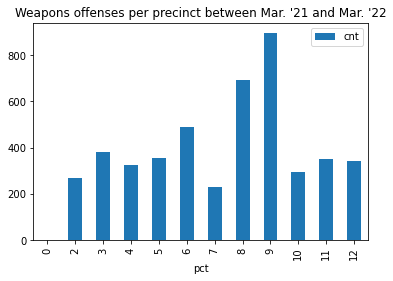

In [71]:
pct_21to22_df = pd.read_sql(pct_21to22_query, con)
pct_21to22_df.plot.bar(x = 'pct', y = 'cnt', title = "Weapons offenses per precinct between Mar. '21 and Mar. '22")

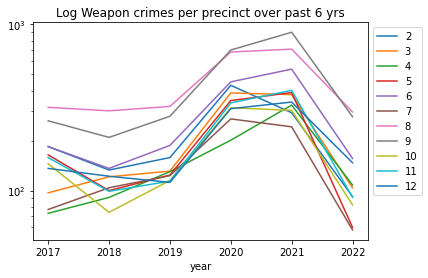

In [72]:
since2016_df = pd.read_sql(pct_since2016_query, con)
since2016_pvt = pd.pivot(since2016_df, columns = 'pct', values = 'cnt', index = 'year')
since2016_pvt.drop([0], axis = 1, inplace=True)
lines_2016 = since2016_pvt.plot.line(logy = True, title = 'Log Weapon crimes per precinct over past 6 yrs')
lines_2016.legend(bbox_to_anchor=(1.0, 1.0))

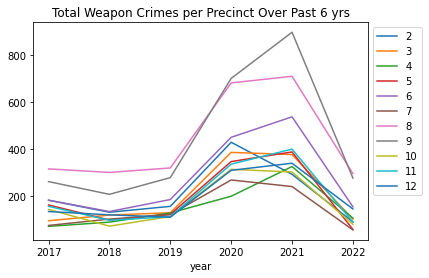

In [73]:
lines_2016 = since2016_pvt.plot.line(title = 'Total Weapon Crimes per Precinct Over Past 6 yrs')
lines_2016.legend(bbox_to_anchor=(1.0, 1.0))

In [74]:
since2016_bytreatment_df = pd.read_sql(since2016_bytreatment_query, con)
since2016_bytreatment_pvt = pd.pivot(since2016_bytreatment_df, columns = 'ss_zone', values = 'cnt', index = 'year')
since2016_bytreatment_pvt['ss_pct_change'] = since2016_bytreatment_pvt['ss_zone'].pct_change()
since2016_bytreatment_pvt['out_ss_pct_change'] = since2016_bytreatment_pvt['outside_ss_zone'].pct_change()
since2016_bytreatment_pvt

ss_zone,outside_ss_zone,ss_zone,ss_pct_change,out_ss_pct_change
year,,,,
2017,771,1027,NaN,NaN
2018,809,682,-0.335930,0.049287
2019,1032,764,0.120235,0.275649
2020,2641,1792,1.345550,1.559109
2021,3657,1164,-0.350446,0.384703
2022,986,488,-0.580756,-0.730380


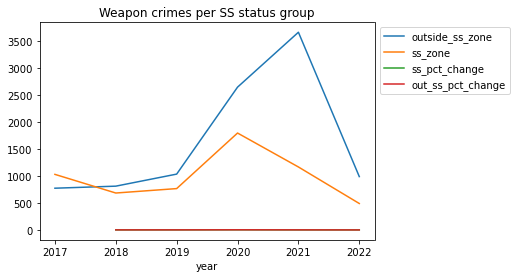

In [75]:
lines_2016_bytmt = since2016_bytreatment_pvt.plot.line(title = 'Weapon crimes per SS status group')
lines_2016_bytmt.legend(bbox_to_anchor=(1.0, 1.0))

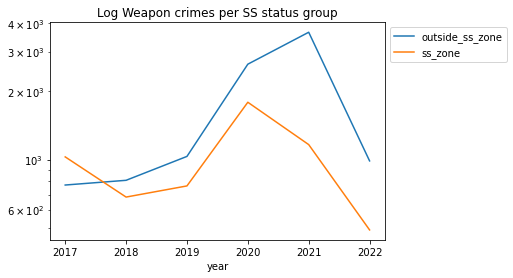

In [76]:
since2016_bytreatment_pvt.drop(['ss_pct_change', 'out_ss_pct_change'], axis = 1, inplace = True)
lines_2016_bytmt = since2016_bytreatment_pvt.plot.line(logy = True, title ='Log Weapon crimes per SS status group')
lines_2016_bytmt.legend(bbox_to_anchor=(1.0, 1.0))